In [1]:
from atmos import OceanRad
import pymap3d as pm
import numpy as np
import spectral as sp

In [2]:
anc_file_path = "/home/notebook/cogs/remoy_202208310800_ntnu_hyperspectral_74m/processed/Output/GIS/AncillaryData/remoy_202208310800_ntnu_hyperspectral_74m_transectnr_5_chunknr_0_north_east.hdr"
# The written ancillary data lis of band names is contained within *.hdr file
anc_image_object = sp.io.envi.open(anc_file_path)
anc_band_list = anc_image_object.metadata['band names']
anc_nodata = float(anc_image_object.metadata['data ignore value'])


# The pixel number in gridded form can e.g. be plotted
unix_time_grid = anc_image_object[:,:, anc_band_list.index('unix_time_grid')]
altitude_grid_msl = anc_image_object[:,:, anc_band_list.index('hsi_alts_msl')]

# Create a generic mask
mask_nodata = np.zeros(unix_time_grid.shape, dtype = bool)
mask_nodata[unix_time_grid != anc_nodata] = True

# Find the lon-lat-
x_ecef = anc_image_object[:,:, anc_band_list.index('position_ecef_0')][mask_nodata].mean()
y_ecef = anc_image_object[:,:, anc_band_list.index('position_ecef_1')][mask_nodata].mean()
z_ecef = anc_image_object[:,:, anc_band_list.index('position_ecef_2')][mask_nodata].mean()

lat, lon, _ = pm.ecef2geodetic(x_ecef,y_ecef, z_ecef)

timestamp_unix = unix_time_grid[mask_nodata].mean()

altitude_msl = altitude_grid_msl[mask_nodata].mean()

# Example usage
radiance_multiplier = (1 / 1000) #(mW/cm^2*sr*um)*1000.0000 ->(mW/cm^2*sr*um)
radiance_multiplier *= (1e-3 / 1e-4) #(mW/cm^2*sr*um) -> (W/m^2*sr*um)
radiance_multiplier *= (1 / 1e3) # (W/m^2*sr*um) -> (W/m^2*sr*nm)

# The written ancillary data list of band names is contained within *.hdr file

spectral_file_path = "/home/notebook/cogs/remoy_202208310800_ntnu_hyperspectral_74m/processed/Output/GIS/HSIDatacubes/remoy_202208310800_ntnu_hyperspectral_74m_transectnr_5_chunknr_0_north_east.hdr"
radiance_spy_object = sp.io.envi.open(spectral_file_path)

radiance_data = {"radiance_spy_object": radiance_spy_object, 
                 "radiance_multiplier": radiance_multiplier,
                 "timestamp_unix": timestamp_unix,
                 "altitude_msl": altitude_msl,
                 "lon": lon,
                 "lat": lat,
                 "mask_nodata": mask_nodata}


orad = OceanRad.from_radiance(radiance_data)

print(type(orad.mask_nodata.squeeze()))

true_indices = np.where(orad.mask_nodata == True)



# Combine row and column indices into a single list of tuples
#flat_indices = list(zip(true_indices[0], true_indices[1]))

print(true_indices[0].shape)

refl = orad.extract_cube_to_spectrum_list(rows = np.array(true_indices[0]), cols = np.array(true_indices[1]))

<class 'numpy.ndarray'>
(4056519,)
The datacube has 30744624 cells
The datacube is 25.65531349182129 GB
The datacube has 3.3850232362747192 GB of actual data
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223


In [3]:
import matplotlib.pyplot as plt
        
#plt.plot(cleaned_wl_sim_arr_um*1e3, cleaned_radiance*radiance_multiplier, label="simulated spectralon")
plt.plot(self.wl, np.array(radiances_resampled)*radiance_multiplier, label="simulated Ed")
plt.xlabel("wavelength (nm)")
plt.ylabel('irradiance (W/m$^2$/nm)')
plt.show()

NameError: name 'self' is not defined

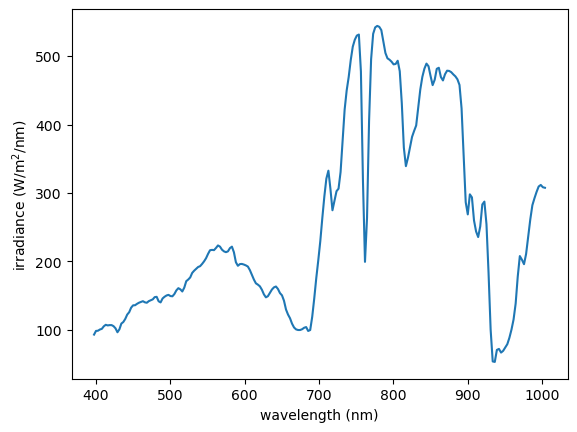

In [5]:
# The spectrum list are the original radiances. 
# Converting them to Rrs reflectance makes a lot of sense.

plt.plot(orad.wl, np.mean(orad.spectrum_list, axis = 0))
plt.xlabel("wavelength (nm)")
plt.ylabel('irradiance (W/m$^2$/nm)')
plt.show()